In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Open words file
words = open('/content/drive/MyDrive/ML Learning/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:5])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# Vocabulary
chars = sorted(list(set(''.join(words))))
itos = {i+1:s for i, s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i, s in itos.items()}
vocab_size = len(itos)

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
# Building the dataset
block_size = 8

def build_dataset(words):
  X, Y = [],[]

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# Splitting into train(80%), dev(10%), test(10%)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtes, Ytes = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [13]:
# Creating Layers
# ------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trainined with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Forward Pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalise to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ------------------------------------------------------------------------------
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# ------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# ------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # get all params in a list

In [14]:
torch.manual_seed(42) # Seed for reproducability

In [15]:
n_embd = 10
n_hidden = 68


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

22397


In [16]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

In [17]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [18]:
max_steps = 200000 # Number of training iterations
batch_size = 32
lossi = []

for i in range(max_steps):

  # Creating mini batches randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # Forward Pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # Loss function

  # Backward pass
  for p in parameters: # Dont forget to reset the gradients to 0
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01 # learning rate decay
  for p in parameters:
      p.data += -lr * p.grad

  # Tracking stats
  if i % 10000 == 0: # printing only every now and then
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3109
  10000/ 200000: 2.1318
  20000/ 200000: 2.3410
  30000/ 200000: 2.2023
  40000/ 200000: 2.0870
  50000/ 200000: 2.2679
  60000/ 200000: 2.0068
  70000/ 200000: 1.9561
  80000/ 200000: 1.9424
  90000/ 200000: 1.7969
 100000/ 200000: 1.6260
 110000/ 200000: 2.4272
 120000/ 200000: 2.2931
 130000/ 200000: 1.9665
 140000/ 200000: 2.1723
 150000/ 200000: 1.7935
 160000/ 200000: 2.0673
 170000/ 200000: 2.2206
 180000/ 200000: 1.9757
 190000/ 200000: 1.9584


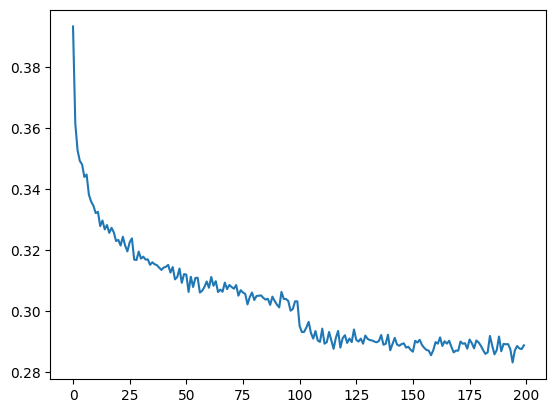

In [19]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # Making the graph look better

In [20]:
# Putting layers into eval mode
for layer in model.layers:
  layer.training = False

In [21]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xtes, Ytes)
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.9226223230361938
dev 2.0245940685272217


# Performance Log
- Original (3 char context + 200 hidden, 12k params) train 2.058, val 2.105
- context increase 3 --> 8: train 1.918, val 2.027
- flat to hierarchical (same network size): train 1.955, val 2.033
- bug fix in batch norm: train:

In [ ]:
# Name generation

for _ in range(10):

  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))